# DEAM Dataset - Feed Forward Neural Network
## Essentia Best All & openSMILE ComParE2016 Featureset

## Import relevant libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torcheval.metrics import R2Score

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import math

import sys
sys.path.insert(1, '../../utils')
from paths import *

## Neural Network Training

### Import annotations dataset

In [2]:
df_annotations = pd.read_csv(get_deam_path('processed/annotations/deam_static_annotations.csv'))
df_annotations

,song_id,valence_mean_mapped,arousal_mean_mapped
0,2,-0.475,-0.500
1,3,-0.375,-0.425
2,4,0.175,0.125
3,5,-0.150,0.075
4,7,0.200,0.350
...,...,...,...
1739,1996,-0.275,0.225
1740,1997,0.075,-0.275
1741,1998,0.350,0.300
1742,1999,-0.100,0.100


### Import the featureset

This is where you should change between normalised and standardised, and untouched featuresets!

In [3]:
df_essentia_all_opensmile_compare2016_features = pd.read_csv(get_deam_path('processed/features/integrated/standardised_essentia_all_opensmile_compare2016_features.csv'))

# drop Unnamed:0 column
df_essentia_all_opensmile_compare2016_features = df_essentia_all_opensmile_compare2016_features[df_essentia_all_opensmile_compare2016_features.columns[1:]]

df_essentia_all_opensmile_compare2016_features

,song_id,lowlevel.average_loudness,lowlevel.barkbands_crest.dmean,lowlevel.barkbands_crest.dmean2,lowlevel.barkbands_crest.dvar,lowlevel.barkbands_crest.dvar2,lowlevel.barkbands_crest.max,lowlevel.barkbands_crest.mean,lowlevel.barkbands_crest.median,lowlevel.barkbands_crest.min,...,mfcc_sma_de[14]_peakRangeAbs,mfcc_sma_de[14]_peakRangeRel,mfcc_sma_de[14]_peakMeanAbs,mfcc_sma_de[14]_peakMeanMeanDist,mfcc_sma_de[14]_peakMeanRel,mfcc_sma_de[14]_minRangeRel,mfcc_sma_de[14]_meanRisingSlope,mfcc_sma_de[14]_stddevRisingSlope,mfcc_sma_de[14]_meanFallingSlope,mfcc_sma_de[14]_stddevFallingSlope
0,2,0.568151,-0.495162,-0.392697,-0.744706,-0.546485,-0.870470,-0.239716,-0.144909,-0.751646,...,-0.631867,-0.365685,-0.279802,-0.282638,1.033912,1.253936,0.258343,-0.101681,0.267050,-0.103648
1,3,-1.189985,-1.329502,-1.219457,-0.832461,-0.787198,1.027719,1.839969,1.739902,0.983723,...,-0.952109,-1.043699,-0.949817,-0.947268,-0.967357,0.042120,-1.127785,-0.883942,-1.084239,-0.561874
2,4,0.650480,-0.120976,-0.098623,-0.270405,-0.093387,-1.198606,-0.493636,-0.348739,-0.673459,...,-0.252214,-0.788912,-0.139047,-0.140901,1.033912,0.889151,-0.026883,0.089203,-0.241184,-0.576476
3,5,0.304588,-0.253761,-0.268728,-0.555905,-0.502125,0.225857,-0.133929,-0.197590,0.271977,...,-0.484816,-1.100697,-0.386997,-0.392154,1.033909,0.387215,-0.513832,-0.330955,-0.729651,-0.400833
4,7,0.651505,-0.965369,-1.022563,-0.383251,-0.509374,-0.011622,1.571188,1.686327,-0.514739,...,-0.679149,0.063000,-1.232202,-1.229221,-0.967357,0.368769,-1.143719,-1.322279,-1.174207,-1.294879
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1739,1996,0.675713,1.006280,1.063360,0.713243,0.633269,-0.779093,-0.607815,-0.681665,-0.013183,...,-0.774443,0.503124,-0.529866,-0.535381,1.033905,-0.030763,-0.263638,-0.737909,0.002047,-0.727175
1740,1997,0.683125,-0.291635,-0.136966,-0.549051,-0.394859,-1.571368,-0.677912,-0.561040,-0.216045,...,-0.029122,-0.435924,-0.013004,-0.020709,1.033884,-0.033798,0.353010,0.525906,0.453648,0.424850
1741,1998,0.291013,0.225089,0.192632,-0.015061,-0.102338,-0.223639,-0.920913,-0.808273,-1.243963,...,-0.697061,1.159923,-0.806402,-0.809586,1.033912,-0.252968,-0.728777,-1.008194,-0.453289,-0.757926
1742,1999,0.577845,0.026765,0.244953,-0.602676,-0.436818,-1.339357,-0.815125,-0.667085,0.293630,...,-0.391407,1.480851,-0.725574,-0.727505,1.033912,-0.852857,-0.127534,-0.522571,-0.095621,-0.490813


In [4]:
df_essentia_all_opensmile_compare2016_features.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1744 entries, 0 to 1743
Data columns (total 10887 columns):
 #      Column                                                    Dtype  
---     ------                                                    -----  
 0      song_id                                                   int64  
 1      lowlevel.average_loudness                                 float64
 2      lowlevel.barkbands_crest.dmean                            float64
 3      lowlevel.barkbands_crest.dmean2                           float64
 4      lowlevel.barkbands_crest.dvar                             float64
 5      lowlevel.barkbands_crest.dvar2                            float64
 6      lowlevel.barkbands_crest.max                              float64
 7      lowlevel.barkbands_crest.mean                             float64
 8      lowlevel.barkbands_crest.median                           float64
 9      lowlevel.barkbands_crest.min                              float64
 1

Join both the featureset and annotation set together

In [5]:
df_essentia_all_opensmile_compare2016_whole = pd.merge(df_essentia_all_opensmile_compare2016_features, df_annotations, how='inner', on='song_id')
df_essentia_all_opensmile_compare2016_whole = df_essentia_all_opensmile_compare2016_whole.drop('song_id', axis=1)
df_essentia_all_opensmile_compare2016_whole

,lowlevel.average_loudness,lowlevel.barkbands_crest.dmean,lowlevel.barkbands_crest.dmean2,lowlevel.barkbands_crest.dvar,lowlevel.barkbands_crest.dvar2,lowlevel.barkbands_crest.max,lowlevel.barkbands_crest.mean,lowlevel.barkbands_crest.median,lowlevel.barkbands_crest.min,lowlevel.barkbands_crest.stdev,...,mfcc_sma_de[14]_peakMeanAbs,mfcc_sma_de[14]_peakMeanMeanDist,mfcc_sma_de[14]_peakMeanRel,mfcc_sma_de[14]_minRangeRel,mfcc_sma_de[14]_meanRisingSlope,mfcc_sma_de[14]_stddevRisingSlope,mfcc_sma_de[14]_meanFallingSlope,mfcc_sma_de[14]_stddevFallingSlope,valence_mean_mapped,arousal_mean_mapped
0,0.568151,-0.495162,-0.392697,-0.744706,-0.546485,-0.870470,-0.239716,-0.144909,-0.751646,-0.806035,...,-0.279802,-0.282638,1.033912,1.253936,0.258343,-0.101681,0.267050,-0.103648,-0.475,-0.500
1,-1.189985,-1.329502,-1.219457,-0.832461,-0.787198,1.027719,1.839969,1.739902,0.983723,0.411352,...,-0.949817,-0.947268,-0.967357,0.042120,-1.127785,-0.883942,-1.084239,-0.561874,-0.375,-0.425
2,0.650480,-0.120976,-0.098623,-0.270405,-0.093387,-1.198606,-0.493636,-0.348739,-0.673459,-0.913741,...,-0.139047,-0.140901,1.033912,0.889151,-0.026883,0.089203,-0.241184,-0.576476,0.175,0.125
3,0.304588,-0.253761,-0.268728,-0.555905,-0.502125,0.225857,-0.133929,-0.197590,0.271977,-0.239829,...,-0.386997,-0.392154,1.033909,0.387215,-0.513832,-0.330955,-0.729651,-0.400833,-0.150,0.075
4,0.651505,-0.965369,-1.022563,-0.383251,-0.509374,-0.011622,1.571188,1.686327,-0.514739,-0.630103,...,-1.232202,-1.229221,-0.967357,0.368769,-1.143719,-1.322279,-1.174207,-1.294879,0.200,0.350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1739,0.675713,1.006280,1.063360,0.713243,0.633269,-0.779093,-0.607815,-0.681665,-0.013183,-0.518090,...,-0.529866,-0.535381,1.033905,-0.030763,-0.263638,-0.737909,0.002047,-0.727175,-0.275,0.225
1740,0.683125,-0.291635,-0.136966,-0.549051,-0.394859,-1.571368,-0.677912,-0.561040,-0.216045,-0.915896,...,-0.013004,-0.020709,1.033884,-0.033798,0.353010,0.525906,0.453648,0.424850,0.075,-0.275
1741,0.291013,0.225089,0.192632,-0.015061,-0.102338,-0.223639,-0.920913,-0.808273,-1.243963,-0.577341,...,-0.806402,-0.809586,1.033912,-0.252968,-0.728777,-1.008194,-0.453289,-0.757926,0.350,0.300
1742,0.577845,0.026765,0.244953,-0.602676,-0.436818,-1.339357,-0.815125,-0.667085,0.293630,-1.528391,...,-0.725574,-0.727505,1.033912,-0.852857,-0.127534,-0.522571,-0.095621,-0.490813,-0.100,0.100


#### Prepare dataframes for the neural network

Perform splitting of the dataframe into training and testing sets

In [6]:
features = df_essentia_all_opensmile_compare2016_features.drop('song_id', axis=1)
features

,lowlevel.average_loudness,lowlevel.barkbands_crest.dmean,lowlevel.barkbands_crest.dmean2,lowlevel.barkbands_crest.dvar,lowlevel.barkbands_crest.dvar2,lowlevel.barkbands_crest.max,lowlevel.barkbands_crest.mean,lowlevel.barkbands_crest.median,lowlevel.barkbands_crest.min,lowlevel.barkbands_crest.stdev,...,mfcc_sma_de[14]_peakRangeAbs,mfcc_sma_de[14]_peakRangeRel,mfcc_sma_de[14]_peakMeanAbs,mfcc_sma_de[14]_peakMeanMeanDist,mfcc_sma_de[14]_peakMeanRel,mfcc_sma_de[14]_minRangeRel,mfcc_sma_de[14]_meanRisingSlope,mfcc_sma_de[14]_stddevRisingSlope,mfcc_sma_de[14]_meanFallingSlope,mfcc_sma_de[14]_stddevFallingSlope
0,0.568151,-0.495162,-0.392697,-0.744706,-0.546485,-0.870470,-0.239716,-0.144909,-0.751646,-0.806035,...,-0.631867,-0.365685,-0.279802,-0.282638,1.033912,1.253936,0.258343,-0.101681,0.267050,-0.103648
1,-1.189985,-1.329502,-1.219457,-0.832461,-0.787198,1.027719,1.839969,1.739902,0.983723,0.411352,...,-0.952109,-1.043699,-0.949817,-0.947268,-0.967357,0.042120,-1.127785,-0.883942,-1.084239,-0.561874
2,0.650480,-0.120976,-0.098623,-0.270405,-0.093387,-1.198606,-0.493636,-0.348739,-0.673459,-0.913741,...,-0.252214,-0.788912,-0.139047,-0.140901,1.033912,0.889151,-0.026883,0.089203,-0.241184,-0.576476
3,0.304588,-0.253761,-0.268728,-0.555905,-0.502125,0.225857,-0.133929,-0.197590,0.271977,-0.239829,...,-0.484816,-1.100697,-0.386997,-0.392154,1.033909,0.387215,-0.513832,-0.330955,-0.729651,-0.400833
4,0.651505,-0.965369,-1.022563,-0.383251,-0.509374,-0.011622,1.571188,1.686327,-0.514739,-0.630103,...,-0.679149,0.063000,-1.232202,-1.229221,-0.967357,0.368769,-1.143719,-1.322279,-1.174207,-1.294879
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1739,0.675713,1.006280,1.063360,0.713243,0.633269,-0.779093,-0.607815,-0.681665,-0.013183,-0.518090,...,-0.774443,0.503124,-0.529866,-0.535381,1.033905,-0.030763,-0.263638,-0.737909,0.002047,-0.727175
1740,0.683125,-0.291635,-0.136966,-0.549051,-0.394859,-1.571368,-0.677912,-0.561040,-0.216045,-0.915896,...,-0.029122,-0.435924,-0.013004,-0.020709,1.033884,-0.033798,0.353010,0.525906,0.453648,0.424850
1741,0.291013,0.225089,0.192632,-0.015061,-0.102338,-0.223639,-0.920913,-0.808273,-1.243963,-0.577341,...,-0.697061,1.159923,-0.806402,-0.809586,1.033912,-0.252968,-0.728777,-1.008194,-0.453289,-0.757926
1742,0.577845,0.026765,0.244953,-0.602676,-0.436818,-1.339357,-0.815125,-0.667085,0.293630,-1.528391,...,-0.391407,1.480851,-0.725574,-0.727505,1.033912,-0.852857,-0.127534,-0.522571,-0.095621,-0.490813


In [7]:
targets = df_annotations.drop('song_id', axis=1)
targets

,valence_mean_mapped,arousal_mean_mapped
0,-0.475,-0.500
1,-0.375,-0.425
2,0.175,0.125
3,-0.150,0.075
4,0.200,0.350
...,...,...
1739,-0.275,0.225
1740,0.075,-0.275
1741,0.350,0.300
1742,-0.100,0.100


Perform 80-20 train-test split

In [8]:
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.2, random_state=42)

Create tensors for X_train and X_test

In [9]:
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float64)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float64)

Create tensors for Y_train and Y_test

In [10]:
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float64)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float64)

Define neural network parameters and instantitate neural network

In [11]:
input_size = 1
hidden_size = 20 
output_size = 2  # Output size for valence and arousal
learning_rate = 0.001
criterion = nn.MSELoss()
num_epochs = 300

Define the neural network

In [12]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size):
        super(NeuralNetwork, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), 2)
        )

    def forward(self, x):
        return self.layers(x)

#### Training

Prepare input_train_data and target_train_labels

In [13]:
input_train_data = X_train_tensor.float()

# input_train_data = input_train_data.view(input_train_data.shape[1], -1)
print(input_train_data.shape)

target_train_labels = y_train_tensor

torch.Size([1395, 10886])


Training loop

In [14]:
def train_model(num_epochs):
  model = NeuralNetwork(input_size=input_train_data.shape[1])
  optimiser = optim.Adam(model.parameters(), lr=learning_rate)
  
  for epoch in range(num_epochs):
    optimiser.zero_grad()
    
    # forward pass
    output = model(input_train_data)

    # calculate loss
    loss = torch.sqrt(criterion(output.float(), target_train_labels.float()))

    # backward pass
    loss.backward()
    # update weights
    optimiser.step()

    print(f'Epoch {epoch + 1}, Loss: {math.sqrt(loss.item())}')

  print("Training completed.")
  return model

In [15]:
model = train_model(num_epochs)

Epoch 1, Loss: 0.5655579100384736
Epoch 2, Loss: 0.5599126118356406
Epoch 3, Loss: 0.5564910955530693
Epoch 4, Loss: 0.5539166372855963
Epoch 5, Loss: 0.5481456980173786
Epoch 6, Loss: 0.5344123961095968
Epoch 7, Loss: 0.5279600992027466
Epoch 8, Loss: 0.51011736197293
Epoch 9, Loss: 0.5016357665457163
Epoch 10, Loss: 0.48773478637365114
Epoch 11, Loss: 0.4743044623351015
Epoch 12, Loss: 0.45854430508869143
Epoch 13, Loss: 0.46370665332228095
Epoch 14, Loss: 0.4449951814808514
Epoch 15, Loss: 0.4509427368113767
Epoch 16, Loss: 0.4439963583710971
Epoch 17, Loss: 0.44412585311923664
Epoch 18, Loss: 0.4379725628842359
Epoch 19, Loss: 0.43032169357152705
Epoch 20, Loss: 0.4254175960513184
Epoch 21, Loss: 0.4246299998337427
Epoch 22, Loss: 0.4223275582966959
Epoch 23, Loss: 0.4166727741111736
Epoch 24, Loss: 0.414581872787331
Epoch 25, Loss: 0.4119259575274438
Epoch 26, Loss: 0.4087088523067063
Epoch 27, Loss: 0.4062210219391824
Epoch 28, Loss: 0.40404130164622293
Epoch 29, Loss: 0.40079552

## Neural Network Testing

Prepare input_test_data and target_test_labels

In [16]:
input_test_data = X_test_tensor.float()

# input_test_data = input_test_data.view(input_test_data.shape[1], -1)
print(input_test_data.shape)

target_test_labels = y_test_tensor

torch.Size([349, 10886])


Generating scores

In [17]:
def test_model(trained_model):
  with torch.no_grad():
    test_pred = trained_model(input_test_data)
    test_loss = criterion(test_pred.float(), target_test_labels)

  rmse = math.sqrt(test_loss.item())
  print(f'Test RMSE: {rmse}')

  metric = R2Score()
  metric.update(test_pred, target_test_labels)
  r2_score = metric.compute().item()
  print(f'Test R^2 score: {r2_score}')
  return test_pred, rmse, r2_score

In [18]:
test_pred, rmse, r2_score = test_model(model)

Test RMSE: 0.19208732643395815
Test R^2 score: 0.5941539951683061


True values (test set)

In [19]:
target_test_labels

tensor([[-0.1500, -0.1500],
        [-0.3000, -0.1000],
        [ 0.2000,  0.3500],
        [ 0.2250,  0.4500],
        [-0.1750, -0.2000],
        [-0.5250, -0.3000],
        [-0.2500, -0.7750],
        [ 0.3000,  0.3000],
        [-0.1750, -0.4000],
        [ 0.4500,  0.1500],
        [ 0.1750,  0.0250],
        [-0.1750, -0.0250],
        [-0.0500, -0.3000],
        [ 0.1250,  0.3000],
        [-0.0750, -0.1500],
        [-0.2000, -0.2750],
        [-0.6000, -0.2250],
        [ 0.1500, -0.2000],
        [ 0.2750,  0.6000],
        [-0.1500, -0.4500],
        [-0.2250, -0.6250],
        [-0.0250, -0.4500],
        [-0.5250, -0.1250],
        [ 0.0000,  0.3250],
        [ 0.1250,  0.3750],
        [ 0.1500, -0.2500],
        [ 0.4500,  0.3250],
        [ 0.2500,  0.2250],
        [-0.1000,  0.0750],
        [ 0.4250,  0.1250],
        [-0.4500, -0.3500],
        [-0.0500,  0.3750],
        [-0.4750, -0.2000],
        [-0.2750, -0.4000],
        [-0.4000, -0.2250],
        [ 0.1000, -0

Predicted values

In [20]:
test_pred

tensor([[ 2.3654e-01,  1.9440e-01],
        [-2.6126e-01, -3.2025e-01],
        [ 5.3695e-01,  3.7098e-01],
        [ 1.7816e-01,  2.9406e-01],
        [-1.2917e-01, -2.7309e-01],
        [-3.2684e-01, -2.4760e-01],
        [-3.1682e-01, -6.5503e-01],
        [ 2.6994e-01,  3.1579e-01],
        [-3.5218e-01, -4.0572e-01],
        [ 4.6423e-01,  4.1059e-01],
        [ 3.3716e-01,  6.6205e-02],
        [-3.8679e-01, -9.5027e-02],
        [ 4.7797e-02, -3.2835e-01],
        [ 1.8912e-01,  2.2309e-01],
        [ 1.6207e-01,  3.8886e-02],
        [-3.1128e-01, -3.9826e-01],
        [-5.0549e-01, -2.6299e-01],
        [-6.6543e-02, -2.7081e-01],
        [ 1.0928e-01,  2.9912e-01],
        [-1.2642e-01, -3.6441e-01],
        [-5.2666e-01, -6.2615e-01],
        [-4.6091e-01, -4.8532e-01],
        [-5.9774e-01, -5.0144e-01],
        [ 1.8861e-01,  3.2078e-01],
        [ 6.5227e-03,  1.8948e-01],
        [ 3.3537e-01,  1.9963e-02],
        [ 4.6018e-01,  4.3680e-01],
        [ 2.9999e-01,  1.239

## Analyse relationship between epochs and r^2 score

Create lists to store the epochs and R^2 scores

In [21]:
num_epochs_list = [i for i in range(1, 301)]
r2_scores_list = []
rmse_list = []

Conduct training and testing for each num_epochs

In [22]:
for num_epochs in num_epochs_list:
  print(f'Num of epochs: {num_epochs}')
  
  model = train_model(num_epochs)

  print("Training completed.")
  print("Testing model...")

  test_pred, rmse, r2_score = test_model(model)
  r2_scores_list.append(r2_score)
  rmse_list.append(rmse)

print("Completed.")

Num of epochs: 1
Epoch 1, Loss: 0.5666696133490223
Training completed.
Training completed.
Testing model...
Test RMSE: 0.3139983223506062
Test R^2 score: -0.07319775458784472
Num of epochs: 2
Epoch 1, Loss: 0.5569685388391404
Epoch 2, Loss: 0.5561678032740082
Training completed.
Training completed.
Testing model...
Test RMSE: 0.3037962792926581
Test R^2 score: -0.006798321095467463
Num of epochs: 3
Epoch 1, Loss: 0.5575656900493152
Epoch 2, Loss: 0.5563364368959366
Epoch 3, Loss: 0.5555958898790508
Training completed.
Training completed.
Testing model...
Test RMSE: 0.2999120048016298
Test R^2 score: 0.02093424897004137
Num of epochs: 4
Epoch 1, Loss: 0.5633362805366543
Epoch 2, Loss: 0.5589271297505884
Epoch 3, Loss: 0.556090796115251
Epoch 4, Loss: 0.5539750641554265
Training completed.
Training completed.
Testing model...
Test RMSE: 0.2963815033199913
Test R^2 score: 0.040008378750819196
Num of epochs: 5
Epoch 1, Loss: 0.5567742170677694
Epoch 2, Loss: 0.5561680979921287
Epoch 3, Los

### Plot the graph to visualise the relationship between epochs and r^2 score

Import relevant libraries

In [23]:
import matplotlib.pyplot as plt

In [24]:
r2_scores_list

[-0.07319775458784472,
 -0.006798321095467463,
 0.02093424897004137,
 0.040008378750819196,
 0.0851431945338591,
 0.1894573182567642,
 0.1842827590679068,
 0.4050915906875355,
 0.2629363476039942,
 0.3646367016500254,
 0.4149777841461526,
 0.4998778269940536,
 0.17300550839773238,
 0.4827585604191554,
 0.36379672147794934,
 0.47999390501101474,
 0.49443277141814623,
 0.5317716496547955,
 0.4980724079763295,
 0.5492987054291247,
 0.5365194780985819,
 0.5139081566747727,
 0.536229350692372,
 0.5398003628340162,
 0.5486904527032547,
 0.5360265282873415,
 0.5242682097223434,
 0.541964581339474,
 0.5310556614647666,
 0.5305691737219963,
 0.5395540447373544,
 0.5500715567358022,
 0.5275808452388457,
 0.540497976579611,
 0.5454395027506159,
 0.528896286245886,
 0.5235841885754207,
 0.5262621487121801,
 0.5320790924890769,
 0.5752634095529978,
 0.5366428411887718,
 0.5490911103886571,
 0.5381888368457275,
 0.5581440658704291,
 0.5340836289546809,
 0.5571812165786701,
 0.5494257983527038,
 0.52

Plot the line graph

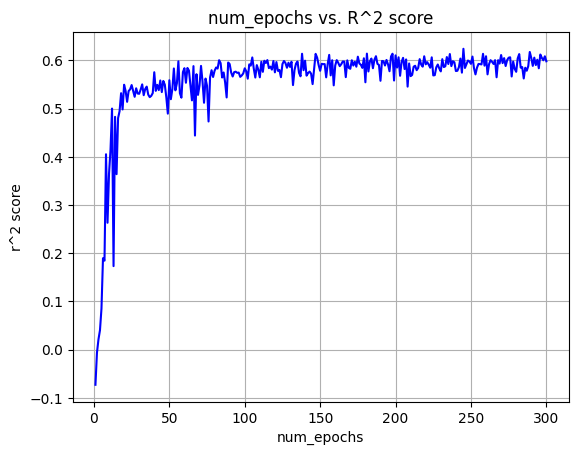

In [25]:
plt.plot(num_epochs_list, r2_scores_list, color='b', linestyle='-')
plt.title('num_epochs vs. R^2 score')
plt.xlabel('num_epochs')
plt.ylabel('r^2 score') 
plt.grid(True)
plt.show() 

In [26]:
max_r2_score = max(r2_scores_list)
corresponding_rmse = rmse_list[r2_scores_list.index(max_r2_score)]
corresponding_num_epochs = num_epochs_list[r2_scores_list.index(max_r2_score)]

print(f'Max R^2 score: {max_r2_score}')
print(f'Corresponding RMSE: {corresponding_rmse}')
print(f'Corresponding num_epochs: {corresponding_num_epochs}')

Max R^2 score: 0.6239276415159623
Corresponding RMSE: 0.18499089408925848
Corresponding num_epochs: 245
